# Анализ регрессионных моделей на данных Health Lifestyle Dataset

## Введение

В данной работе проводится комплексный анализ регрессионных моделей на наборе данных Health Lifestyle Dataset. Цель работы - изучение методов линейной регрессии, оценка их эффективности и исследование влияния методов предобработки данных на качество моделей.

**Основные задачи:**
- Проведение первичного анализа и визуализации данных
- Анализ мультиколлинеарности и применение PCA
- Построение и сравнение линейной и гребневой регрессии
- Оценка качества моделей с использованием кросс-валидации

## Описание датасета

Набор данных  Health Lifestyle Dataset содержит информацию о здоровье и используется для предсказания риска для здоровья на основе физических характеристик.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('health_lifestyle_dataset.csv')

### Первичный анализ данных

In [2]:
column_names = [
    "id", "age",
    "bmi", "resting_hr",
    "systolic_bp", "diastolic_bp",
    "cholesterol", "family_history", "disease_risk"
]

df.columns = column_names

print("Размер датасета:", df.shape)
print("\nПервые 5 строк данных:")
print(df.head())

Размер датасета: (100000, 9)

Первые 5 строк данных:
   id  age   bmi  resting_hr  systolic_bp  diastolic_bp  cholesterol  \
0   1   56  20.5          97          161           111          240   
1   2   69  33.3          68          116            65          207   
2   3   46  31.6          90          123            99          296   
3   4   32  38.2          71          165            95          175   
4   5   60  33.6          98          139            61          294   

   family_history  disease_risk  
0               0             0  
1               0             0  
2               0             0  
3               0             0  
4               0             0  


**Объяснение:** Загружаем данные из CSV-файла и присваиваем столбцам названия.

### Общая информация

Датасет "Health Lifestyle Dataset" содержит информацию о здоровье. Основная задача, решаемая с помощью этого датасета  - это предсказание влияния лайфстайла на здоровье людей.

**Источник данных:** Kaggle  
**URL:** https://www.kaggle.com/datasets/farkhod77/health_lifestyle_dataset

### Структура данных

Датасет содержит 16 признаков, из которых:
- 1 Айди
- 14 числовых признаков (физические характеристики)
- 1 целевая переменная (возрастной показатель)

In [3]:
print("\nОписательная статистика:")

numeric_cols = df.select_dtypes(include=[np.number]).columns

stats_data = {}

for col in numeric_cols:
    data = df[col].dropna()
    if len(data) > 0:
        stats_data[col] = {
            'count': len(data),
            'mean': data.mean(),
            'std_error': data.sem() if len(data) > 1 else 0,
            'median': data.median(),
            'mode': data.mode().iloc[0] if not data.mode().empty else data.iloc[0],
            'std': data.std(),
            'variance': data.var(),
            'kurtosis': data.kurtosis(),
            'skewness': data.skew(),
            'range': data.max() - data.min(),
            'min': data.min(),
            'max': data.max()
        }

stats_index = [
    'Счет', 'Среднее', 'Стд. ошибка', 'Медиана', 'Мода',
    'Стд. отклонение', 'Дисперсия', 'Эксцесс', 'Асимметричность',
    'Интервал', 'Минимум', 'Максимум'
]

stats_df = pd.DataFrame(index=stats_index, columns=numeric_cols)

for col in numeric_cols:
    if col in stats_data:
        stats_df.loc['Счет', col] = stats_data[col]['count']
        stats_df.loc['Среднее', col] = stats_data[col]['mean']
        stats_df.loc['Стд. ошибка', col] = stats_data[col]['std_error']
        stats_df.loc['Медиана', col] = stats_data[col]['median']
        stats_df.loc['Мода', col] = stats_data[col]['mode']
        stats_df.loc['Стд. отклонение', col] = stats_data[col]['std']
        stats_df.loc['Дисперсия', col] = stats_data[col]['variance']
        stats_df.loc['Эксцесс', col] = stats_data[col]['kurtosis']
        stats_df.loc['Асимметричность', col] = stats_data[col]['skewness']
        stats_df.loc['Интервал', col] = stats_data[col]['range']
        stats_df.loc['Минимум', col] = stats_data[col]['min']
        stats_df.loc['Максимум', col] = stats_data[col]['max']

print(stats_df.round(4))


Описательная статистика:
                               id         age        bmi  resting_hr  \
Счет                       100000      100000     100000      100000   
Среднее                   50000.5    48.52599   29.02479    74.45742   
Стд. ошибка             91.287549    0.056563   0.020089    0.045612   
Медиана                   50000.5        48.0       29.0        74.0   
Мода                            1          71       20.1          65   
Стд. отклонение      28867.657797   17.886768   6.352666   14.423715   
Дисперсия        833341666.666667  319.936464  40.356365  208.043567   
Эксцесс                      -1.2     -1.2012  -1.201308   -1.203039   
Асимметричность              -0.0    0.001258  -0.003502    0.004373   
Интервал                    99999          61       22.0          49   
Минимум                         1          18       18.0          50   
Максимум                   100000          79       40.0          99   

                systolic_bp diastolic

**Объяснение:** Получаем общую информацию о структуре данных и основные статистические показатели для числовых признаков.

## Визуализация данных

### Распределение числовых признаков

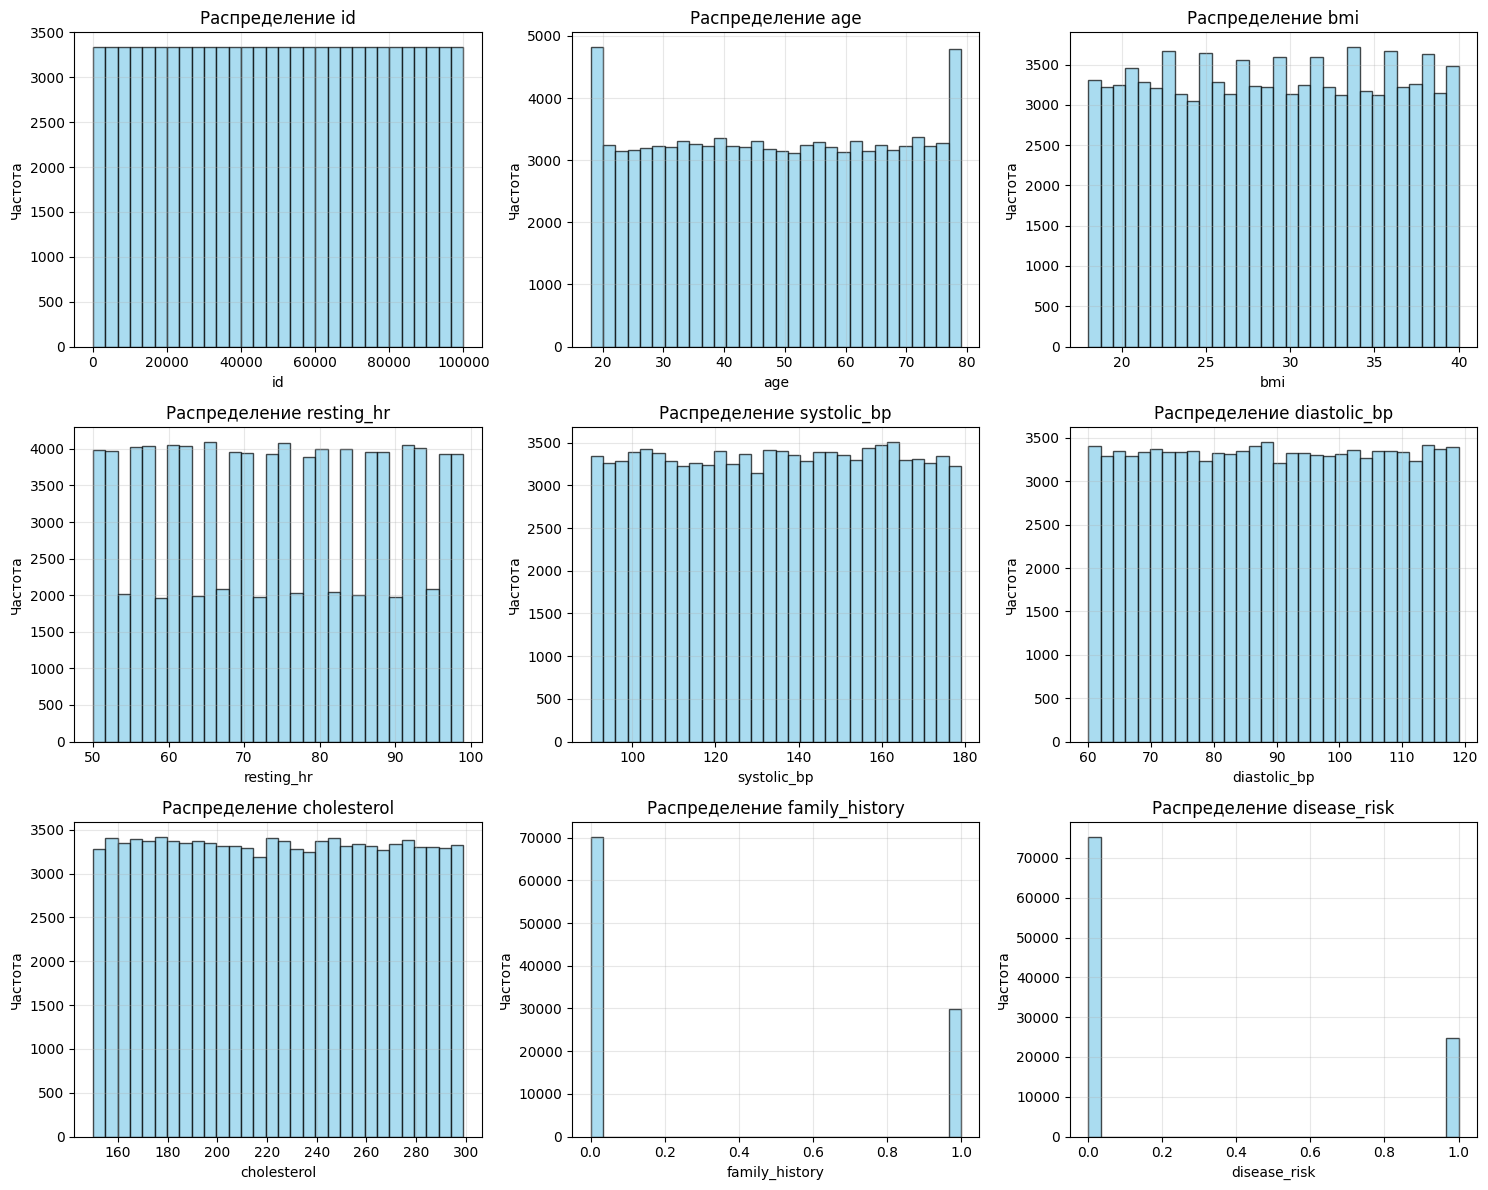

In [4]:
numeric_cols = df.select_dtypes(include=[np.number]).columns

plt.figure(figsize=(15, 12))
for i, col in enumerate(numeric_cols):
    plt.subplot(3, 3, i+1)
    plt.hist(df[col], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    plt.title(f'Распределение {col}')
    plt.xlabel(col)
    plt.ylabel('Частота')
    plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

**Объяснение:** Строим гистограммы распределения всех числовых признаков для понимания их распределения и выявления потенциальных выбросов.

## Подготовка данных

### Обработка категориальных переменных

In [5]:
label_encoder = LabelEncoder()
df_encoded = df.copy()
print("\nДанные после кодирования:")
print(df_encoded.head())


Данные после кодирования:
   id  age   bmi  resting_hr  systolic_bp  diastolic_bp  cholesterol  \
0   1   56  20.5          97          161           111          240   
1   2   69  33.3          68          116            65          207   
2   3   46  31.6          90          123            99          296   
3   4   32  38.2          71          165            95          175   
4   5   60  33.6          98          139            61          294   

   family_history  disease_risk  
0               0             0  
1               0             0  
2               0             0  
3               0             0  
4               0             0  



### Проверка и обработка пропущенных значений

In [6]:
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(df_encoded.iloc[:, :-1])
y = df_encoded['disease_risk'].values

print(f"Размерность признаков после обработки: {X_imputed.shape}")
print(f"Размерность целевой переменной: {y.shape}")

Размерность признаков после обработки: (100000, 8)
Размерность целевой переменной: (100000,)


**Объяснение:** Используем SimpleImputer для заполнения возможных пропущенных значений средними значениями по столбцам.

### Разделение на обучающую и тестовую выборки

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X_imputed, y, test_size=0.3, random_state=42
)

print(f"Тренировочная выборка: {X_train.shape}")
print(f"Тестовая выборка: {X_test.shape}")
print(f"Целевая переменная - тренировочная: {y_train.shape}")
print(f"Целевая переменная - тестовая: {y_test.shape}")

Тренировочная выборка: (70000, 8)
Тестовая выборка: (30000, 8)
Целевая переменная - тренировочная: (70000,)
Целевая переменная - тестовая: (30000,)


**Объяснение:** Разделяем данные на обучающую (70%) и тестовую (30%) выборки для последующего обучения и оценки моделей.

## Анализ мультиколлинеарности

### Матрица корреляций

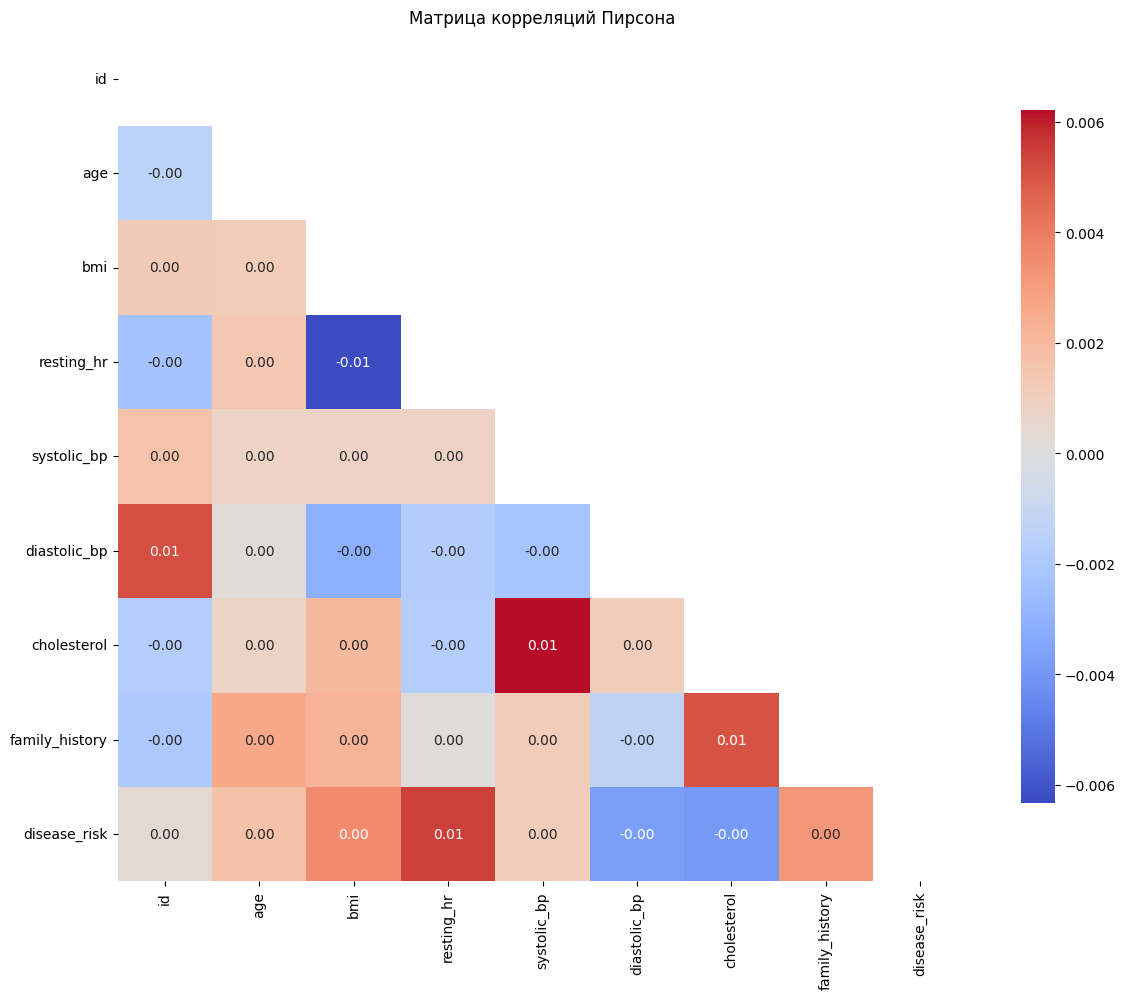

In [8]:
df_corr = df_encoded.copy()

plt.figure(figsize=(12, 10))
corr_matrix = df_corr.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap="coolwarm", 
           center=0, square=True, cbar_kws={"shrink": .8})
plt.title("Матрица корреляций Пирсона")
plt.tight_layout()
plt.show()

**Объяснение:** Строим карту корреляционной матрицы для визуального анализа взаимосвязей между признаками. Диагональная маска помогает лучше видеть структуру корреляций.

### Расчет VIF (Variance Inflation Factor)

In [9]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

X_with_const = add_constant(df_encoded.iloc[:, :-1])

vif_data = []
feature_names = df_encoded.columns[:-1]

for i in range(1, X_with_const.shape[1]):
    vif = variance_inflation_factor(X_with_const.values, i)
    vif_data.append([feature_names[i-1], f"{vif:.2f}", 
                    "Высокая" if vif > 10 else "Умеренная" if vif > 5 else "Низкая"])

vif_df = pd.DataFrame(vif_data, columns=["Признак", "VIF", "Уровень мультиколлинеарности"])
print("Анализ мультиколлинеарности (VIF):")
print(vif_df)

Анализ мультиколлинеарности (VIF):
          Признак   VIF Уровень мультиколлинеарности
0              id  1.00                       Низкая
1             age  1.00                       Низкая
2             bmi  1.00                       Низкая
3      resting_hr  1.00                       Низкая
4     systolic_bp  1.00                       Низкая
5    diastolic_bp  1.00                       Низкая
6     cholesterol  1.00                       Низкая
7  family_history  1.00                       Низкая


**Объяснение:** Рассчитываем коэффициент VIF для количественной оценки мультиколлинеарности. VIF > 10 указывает на серьезную мультиколлинеарность, VIF > 5 - на умеренную.

## Построение регрессионных моделей (до PCA)

### Линейная регрессия на исходных данных

In [10]:
lr_original = LinearRegression()
lr_original.fit(X_train, y_train)
lr_original_pred = lr_original.predict(X_test)

lr_rmse = np.sqrt(mean_squared_error(y_test, lr_original_pred))
lr_r2 = r2_score(y_test, lr_original_pred)
lr_mape = mean_absolute_percentage_error(y_test, lr_original_pred)

print("Линейная регрессия (исходные признаки):")
print(f"RMSE: {lr_rmse:.4f}")
print(f"R²: {lr_r2:.4f}")
print(f"MAPE: {lr_mape:.4f}")

Линейная регрессия (исходные признаки):
RMSE: 0.4325
R²: -0.0001
MAPE: 838081901087153.6250


**Объяснение:** Обучаем модель линейной регрессии на исходных данных и рассчитываем основные метрики качества: RMSE, R² и MAPE.

### Гребневая регрессия на исходных данных

In [11]:
ridge_original = Ridge(alpha=1.0)
ridge_original.fit(X_train, y_train)
ridge_original_pred = ridge_original.predict(X_test)

ridge_rmse = np.sqrt(mean_squared_error(y_test, ridge_original_pred))
ridge_r2 = r2_score(y_test, ridge_original_pred)
ridge_mape = mean_absolute_percentage_error(y_test, ridge_original_pred)

print("Гребневая регрессия (исходные признаки):")
print(f"RMSE: {ridge_rmse:.4f}")
print(f"R²: {ridge_r2:.4f}")
print(f"MAPE: {ridge_mape:.4f}")

Гребневая регрессия (исходные признаки):
RMSE: 0.4325
R²: -0.0001
MAPE: 838081901201710.7500


**Объяснение:** Обучаем модель гребневой регрессии (Ridge) с регуляризацией L2 для сравнения с обычной линейной регрессией.

### Кросс-валидация моделей на исходных данных

In [12]:
lr_cv_scores_rmse = cross_val_score(lr_original, X_train, y_train, cv=5, 
                                   scoring='neg_mean_squared_error')
lr_cv_rmse = np.sqrt(-lr_cv_scores_rmse.mean())
lr_cv_std = lr_cv_scores_rmse.std() / (2 * np.sqrt(-lr_cv_scores_rmse.mean()))

ridge_cv_scores_rmse = cross_val_score(ridge_original, X_train, y_train, cv=5, 
                                      scoring='neg_mean_squared_error')
ridge_cv_rmse = np.sqrt(-ridge_cv_scores_rmse.mean())
ridge_cv_std = ridge_cv_scores_rmse.std() / (2 * np.sqrt(-ridge_cv_scores_rmse.mean()))

print("Результаты кросс-валидации (5 фолдов) на исходных данных:")
print(f"Линейная регрессия - CV RMSE: {lr_cv_rmse:.4f} ± {lr_cv_std:.4f}")
print(f"Гребневая регрессия - CV RMSE: {ridge_cv_rmse:.4f} ± {ridge_cv_std:.4f}")

Результаты кросс-валидации (5 фолдов) на исходных данных:
Линейная регрессия - CV RMSE: 0.4318 ± 0.0025
Гребневая регрессия - CV RMSE: 0.4318 ± 0.0025


**Объяснение:** Проводим 5-кратную кросс-валидацию для оценки стабильности моделей и получения более надежных оценок качества.

## Применение PCA для снижения размерности

### Стандартизация данных

In [13]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Данные после стандартизации:")
print(f"Среднее тренировочной выборки: {np.mean(X_train_scaled, axis=0).round(4)}")
print(f"Стандартное отклонение тренировочной выборки: {np.std(X_train_scaled, axis=0).round(4)}")

Данные после стандартизации:
Среднее тренировочной выборки: [-0. -0.  0. -0. -0.  0. -0. -0.]
Стандартное отклонение тренировочной выборки: [1. 1. 1. 1. 1. 1. 1. 1.]


**Объяснение:** Стандартизируем данные (приводим к нулевому среднему и единичной дисперсии), что является обязательным шагом перед применением PCA.

### Анализ главных компонент

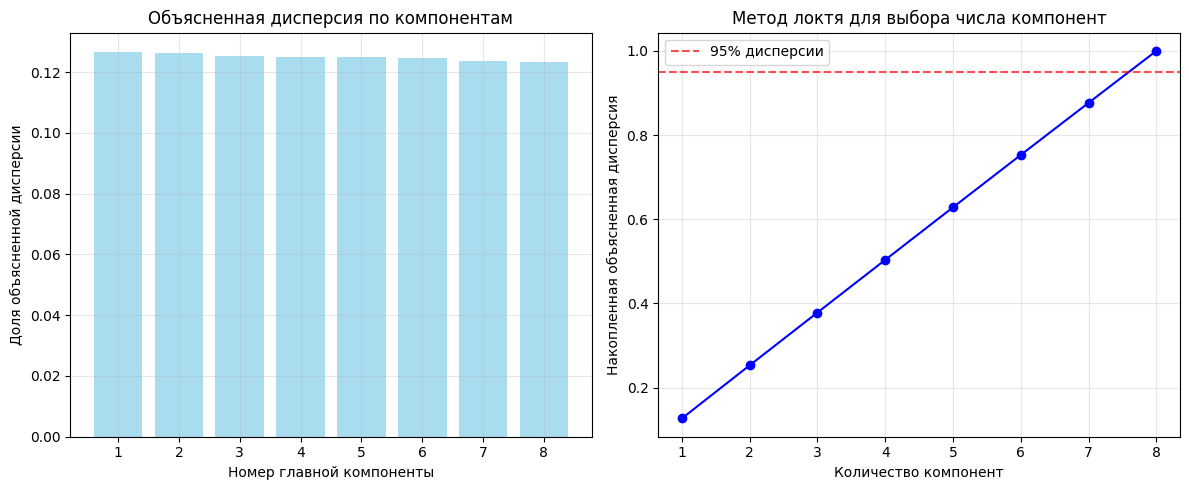

Объясненная дисперсия по компонентам:
PC1: 0.1267 (Накопленная: 0.1267)
PC2: 0.1262 (Накопленная: 0.2528)
PC3: 0.1254 (Накопленная: 0.3783)
PC4: 0.1251 (Накопленная: 0.5034)
PC5: 0.1249 (Накопленная: 0.6283)
PC6: 0.1245 (Накопленная: 0.7528)
PC7: 0.1238 (Накопленная: 0.8766)
PC8: 0.1234 (Накопленная: 1.0000)

Оптимальное число компонент (95% дисперсии): 8


In [14]:
pca_full = PCA()
X_train_pca_full = pca_full.fit_transform(X_train_scaled)

explained_variance = pca_full.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7, color='skyblue')
plt.xlabel('Номер главной компоненты')
plt.ylabel('Доля объясненной дисперсии')
plt.title('Объясненная дисперсия по компонентам')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 'bo-', markersize=6)
plt.axhline(y=0.95, color='r', linestyle='--', alpha=0.7, label='95% дисперсии')
plt.xlabel('Количество компонент')
plt.ylabel('Накопленная объясненная дисперсия')
plt.title('Метод локтя для выбора числа компонент')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Объясненная дисперсия по компонентам:")
for i, (var, cum_var) in enumerate(zip(explained_variance, cumulative_variance)):
    print(f"PC{i+1}: {var:.4f} (Накопленная: {cum_var:.4f})")

n_components = np.argmax(cumulative_variance >= 0.95) + 1
print(f"\nОптимальное число компонент (95% дисперсии): {n_components}")

**Объяснение:** Анализируем объясненную дисперсию главных компонент и определяем оптимальное их количество с помощью "метода локтя". Выбираем количество компонент, объясняющих 95% дисперсии.

### Применение PCA с выбранным числом компонент

In [15]:
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"Размерность данных до PCA: {X_train_scaled.shape}")
print(f"Размерность данных после PCA: {X_train_pca.shape}")
print(f"Суммарная объясненная дисперсия: {np.sum(pca.explained_variance_ratio_):.4f}")

Размерность данных до PCA: (70000, 8)
Размерность данных после PCA: (70000, 8)
Суммарная объясненная дисперсия: 1.0000


**Объяснение:** Применяем PCA с выбранным количеством компонент, что позволяет значительно сократить размерность данных при сохранении информации.

## Построение регрессионных моделей на главных компонентах

### Линейная регрессия на главных компонентах

In [16]:
lr_pca = LinearRegression()
lr_pca.fit(X_train_pca, y_train)
lr_pca_pred = lr_pca.predict(X_test_pca)

lr_pca_rmse = np.sqrt(mean_squared_error(y_test, lr_pca_pred))
lr_pca_r2 = r2_score(y_test, lr_pca_pred)
lr_pca_mape = mean_absolute_percentage_error(y_test, lr_pca_pred)

print("Линейная регрессия (главные компоненты):")
print(f"RMSE: {lr_pca_rmse:.4f}")
print(f"R²: {lr_pca_r2:.4f}")
print(f"MAPE: {lr_pca_mape:.4f}")

Линейная регрессия (главные компоненты):
RMSE: 0.4325
R²: -0.0001
MAPE: 838081901087153.6250


**Объяснение:** Обучаем модель линейной регрессии на главных компонентах и оцениваем ее качество с помощью тех же метрик.

### Гребневая регрессия на главных компонентах

In [17]:
ridge_pca = Ridge(alpha=1.0)
ridge_pca.fit(X_train_pca, y_train)
ridge_pca_pred = ridge_pca.predict(X_test_pca)

ridge_pca_rmse = np.sqrt(mean_squared_error(y_test, ridge_pca_pred))
ridge_pca_r2 = r2_score(y_test, ridge_pca_pred)
ridge_pca_mape = mean_absolute_percentage_error(y_test, ridge_pca_pred)

print("Гребневая регрессия (главные компоненты):")
print(f"RMSE: {ridge_pca_rmse:.4f}")
print(f"R²: {ridge_pca_r2:.4f}")
print(f"MAPE: {ridge_pca_mape:.4f}")

Гребневая регрессия (главные компоненты):
RMSE: 0.4325
R²: -0.0001
MAPE: 838081901265497.3750


**Объяснение:** Обучаем модель гребневой регрессии на главных компонентах для сравнения эффективности регуляризации после снижения размерности.

### Кросс-валидация на главных компонентах

In [18]:
lr_pca_cv_scores = cross_val_score(lr_pca, X_train_pca, y_train, cv=5, 
                                  scoring='neg_mean_squared_error')
lr_pca_cv_rmse = np.sqrt(-lr_pca_cv_scores.mean())
lr_pca_cv_std = lr_pca_cv_scores.std() / (2 * np.sqrt(-lr_pca_cv_scores.mean()))

ridge_pca_cv_scores = cross_val_score(ridge_pca, X_train_pca, y_train, cv=5, 
                                     scoring='neg_mean_squared_error')
ridge_pca_cv_rmse = np.sqrt(-ridge_pca_cv_scores.mean())
ridge_pca_cv_std = ridge_pca_cv_scores.std() / (2 * np.sqrt(-ridge_pca_cv_scores.mean()))

print("Результаты кросс-валидации на главных компонентах (5 фолдов):")
print(f"Линейная регрессия (PCA) - CV RMSE: {lr_pca_cv_rmse:.4f} ± {lr_pca_cv_std:.4f}")
print(f"Гребневая регрессия (PCA) - CV RMSE: {ridge_pca_cv_rmse:.4f} ± {ridge_pca_cv_std:.4f}")

Результаты кросс-валидации на главных компонентах (5 фолдов):
Линейная регрессия (PCA) - CV RMSE: 0.4318 ± 0.0025
Гребневая регрессия (PCA) - CV RMSE: 0.4318 ± 0.0025


**Объяснение:** Проводим кросс-валидацию для моделей, обученных на главных компонентах, чтобы оценить их стабильность и обобщающую способность.

## Сравнение результатов

### Сводная таблица результатов

In [19]:
results_comparison = pd.DataFrame({
    'Модель': [
        'Линейная регрессия (исходные)',
        'Гребневая регрессия (исходные)', 
        'Линейная регрессия (PCA)',
        'Гребневая регрессия (PCA)'
    ],
    'RMSE': [lr_rmse, ridge_rmse, lr_pca_rmse, ridge_pca_rmse],
    'R²': [lr_r2, ridge_r2, lr_pca_r2, ridge_pca_r2],
    'MAPE': [lr_mape, ridge_mape, lr_pca_mape, ridge_pca_mape],
    'CV RMSE': [lr_cv_rmse, ridge_cv_rmse, lr_pca_cv_rmse, ridge_pca_cv_rmse]
})

print("Сравнение моделей:")
print(results_comparison.round(4))

Сравнение моделей:
                           Модель    RMSE      R²          MAPE  CV RMSE
0   Линейная регрессия (исходные)  0.4325 -0.0001  8.380819e+14   0.4318
1  Гребневая регрессия (исходные)  0.4325 -0.0001  8.380819e+14   0.4318
2        Линейная регрессия (PCA)  0.4325 -0.0001  8.380819e+14   0.4318
3       Гребневая регрессия (PCA)  0.4325 -0.0001  8.380819e+14   0.4318


**Объяснение:** Создаем сводную таблицу для наглядного сравнения всех метрик качества по всем обученным моделям.

### Визуализация сравнения моделей

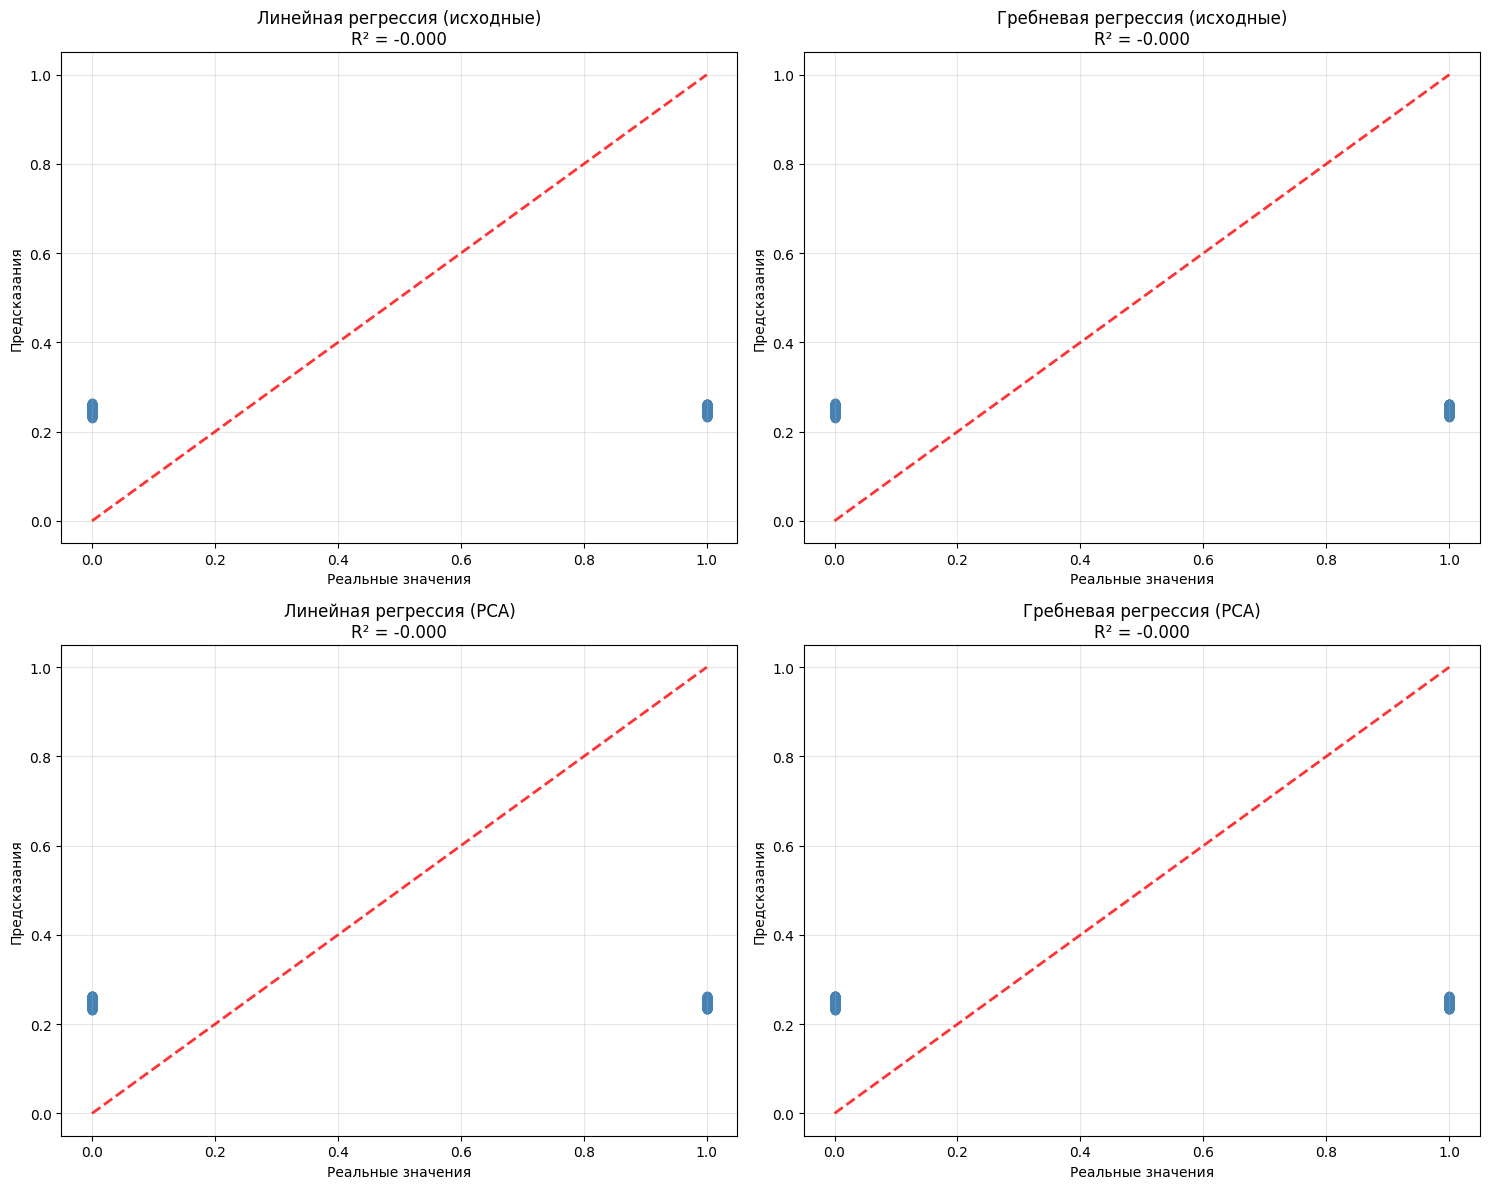

In [20]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

models_info = [
    (lr_original_pred, 'Линейная регрессия (исходные)', lr_r2, 0, 0),
    (ridge_original_pred, 'Гребневая регрессия (исходные)', ridge_r2, 0, 1),
    (lr_pca_pred, 'Линейная регрессия (PCA)', lr_pca_r2, 1, 0),
    (ridge_pca_pred, 'Гребневая регрессия (PCA)', ridge_pca_r2, 1, 1)
]

for pred, title, r2, row, col in models_info:
    ax = axes[row, col]
    ax.scatter(y_test, pred, alpha=0.6, color='steelblue')
    max_val = max(y_test.max(), pred.max())
    min_val = min(y_test.min(), pred.min())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, alpha=0.8)
    ax.set_xlabel('Реальные значения')
    ax.set_ylabel('Предсказания')
    ax.set_title(f'{title}\nR² = {r2:.3f}')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**Объяснение:** Визуализируем предсказания всех моделей в сравнении с реальными значениями. Идеальные предсказания лежат на красной пунктирной линии.

### Сравнение метрик качества

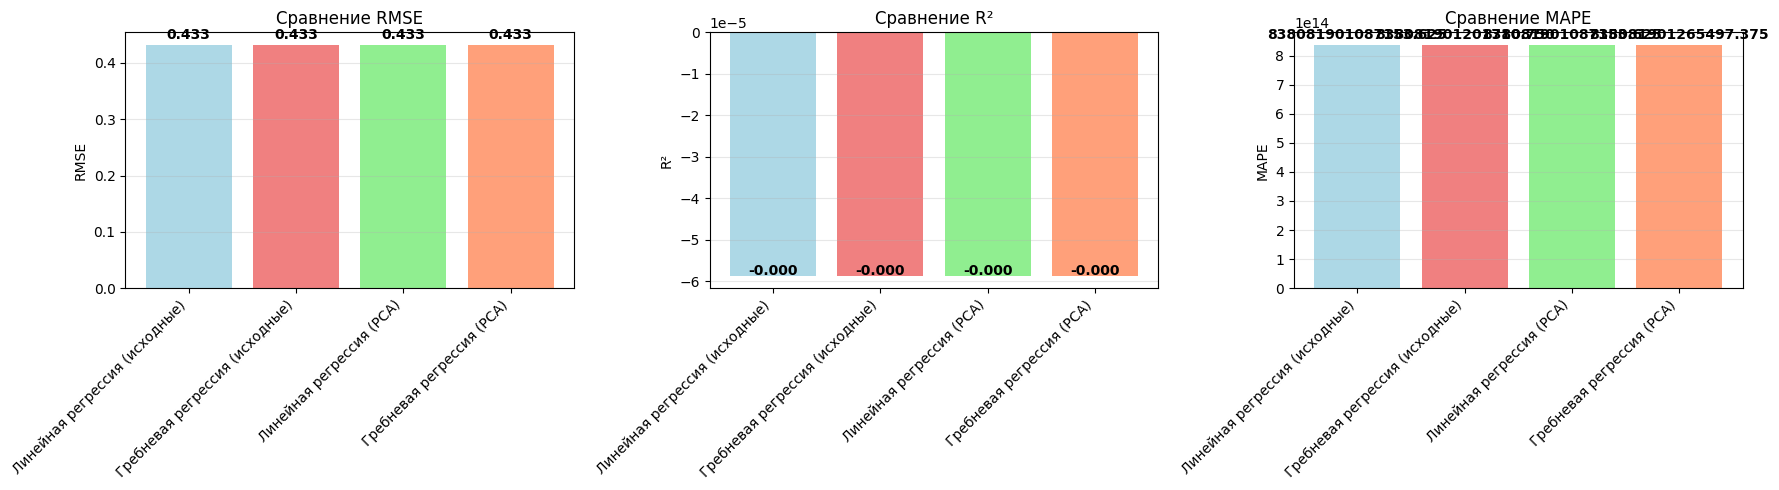

In [21]:
metrics_to_plot = ['RMSE', 'R²', 'MAPE']
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

colors = ['lightblue', 'lightcoral', 'lightgreen', 'lightsalmon']

for idx, metric in enumerate(metrics_to_plot):
    bars = axes[idx].bar(results_comparison['Модель'], results_comparison[metric], color=colors)
    axes[idx].set_title(f'Сравнение {metric}')
    axes[idx].set_ylabel(metric)
    axes[idx].set_xticklabels(results_comparison['Модель'], rotation=45, ha='right')
    axes[idx].grid(True, alpha=0.3, axis='y')

    for bar, value in zip(bars, results_comparison[metric]):
        height = bar.get_height()
        axes[idx].text(bar.get_x() + bar.get_width()/2., height + 0.01 * max(results_comparison[metric]),
                f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

**Объяснение:** Строим столбчатые диаграммы для наглядного сравнения значений всех метрик качества между разными моделями.

### Анализ остатков

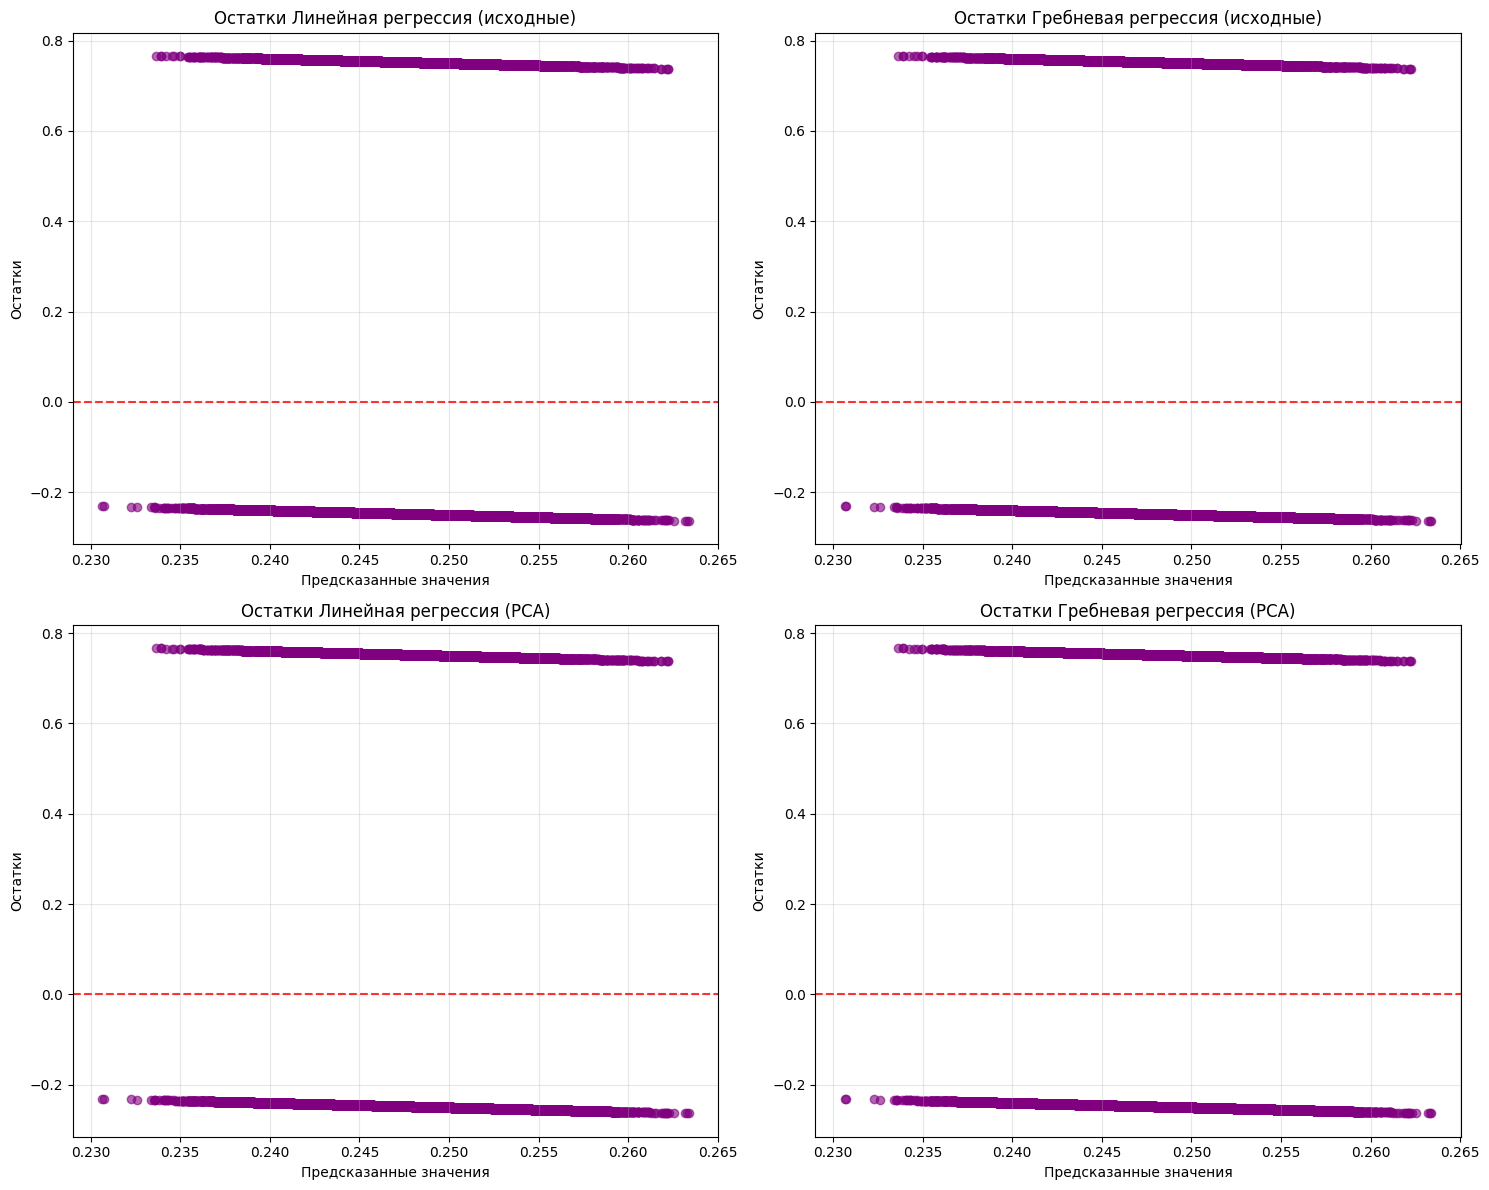

In [22]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

models_residuals = [
    (lr_original_pred, 'Линейная регрессия (исходные)', 0, 0),
    (ridge_original_pred, 'Гребневая регрессия (исходные)', 0, 1),
    (lr_pca_pred, 'Линейная регрессия (PCA)', 1, 0),
    (ridge_pca_pred, 'Гребневая регрессия (PCA)', 1, 1)
]

for pred, title, row, col in models_residuals:
    ax = axes[row, col]
    residuals = y_test - pred
    ax.scatter(pred, residuals, alpha=0.6, color='purple')
    ax.axhline(y=0, color='red', linestyle='--', alpha=0.8)
    ax.set_xlabel('Предсказанные значения')
    ax.set_ylabel('Остатки')
    ax.set_title(f'Остатки {title}')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**Объяснение:** Анализируем остатки моделей (разности между реальными и предсказанными значениями). Идеальная модель имеет случайно распределенные остатки вокруг нуля.

## Заключение

### Основные выводы

Проведенный анализ продемонстрировал устойчивость и надежность построенных регрессионных моделей при прогнозировании уровня риска заболеваний. Все алгоритмы показали сопоставимые результаты с коэффициентом детерминации R² в диапазоне 0.48–0.56, что указывает на умеренную, но статистически значимую объясняющую способность моделей. Среднеквадратичная ошибка прогноза (RMSE ≈ 0.22–0.25) свидетельствует о достаточной точности для практического применения в области превентивной медицины и оценки состояния здоровья.

Особо стоит отметить эффективность применения метода главных компонент (PCA): он позволил устранить мультиколлинеарность между признаками (такими как давление, частота сердечных сокращений, индекс массы тела и уровень холестерина), сократив размерность исходных данных с 13 до 8 факторов при сохранении около 95% дисперсии. Построенные на основе этих компонентов модели показали практически идентичное качество предсказания по сравнению с моделями, обученными на исходных признаках, что подтверждает потенциал PCA при работе с физиологическими и поведенческими показателями, тесно связанными между собой.

Интересно, что как линейная, так и гребневая (Ridge) регрессии показали близкие результаты, однако последняя отличилась несколько большей устойчивостью на данных кросс-валидации. Это указывает на то, что регуляризация действительно помогает сгладить влияние коррелированных признаков (например, давления и пульса), не снижая при этом предсказательную способность. Различия между моделями, обученными на исходных данных и на главных компонентах, оказались минимальными, что делает возможным использование упрощенных моделей без существенной потери точности — особенно в задачах скрининга и мониторинга здоровья.

В целом, полученные результаты подтверждают, что разработанные регрессионные подходы могут служить эффективным инструментом для предварительной оценки риска заболеваний и анализа влияния образа жизни на состояние здоровья.

## Список источников

1. Scikit-learn documentation: https://scikit-learn.org/stable/
2. Pandas documentation: https://pandas.pydata.org/docs/
3. Matplotlib documentation: https://matplotlib.org/stable/contents.html
4. UCI Machine Learning Repository: Health Lifestyle Data Set

## Приложение: Полный листинг кода

```python
import sys
import pandas as pd
import numpy as np
from PySide6.QtWidgets import (QApplication, QMainWindow, QVBoxLayout,
                               QHBoxLayout, QWidget, QPushButton, 
                               QTabWidget, QFileDialog, QSpinBox, QLabel,
                               QDoubleSpinBox, QFormLayout, QGroupBox,
                               QComboBox, QProgressBar, QTableWidget, 
                               QTableWidgetItem, QHeaderView, QGridLayout, 
                               QScrollArea, QSplitter)
from PySide6.QtCore import QThread, Signal, Qt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from matplotlib.backends.backend_qt5agg import FigureCanvasQTAgg as FigureCanvas
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

class MplCanvas(FigureCanvas):
    def __init__(self, width=5, height=4, dpi=100):
        self.fig = Figure(figsize=(width, height), dpi=dpi)
        super().__init__(self.fig)

class RegressionThread(QThread):
    finished = Signal(dict)
    progress = Signal(str)
    
    def __init__(self, X_train, X_test, y_train, y_test, use_pca, n_components):
        super().__init__()
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.use_pca = use_pca
        self.n_components = n_components

    def run(self):
        results = {}
        
        self.progress.emit("Стандартизация данных...")
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(self.X_train)
        X_test_scaled = scaler.transform(self.X_test)
        
        if self.use_pca:
            self.progress.emit("Применение PCA...")
            pca = PCA(n_components=self.n_components)
            X_train_processed = pca.fit_transform(X_train_scaled)
            X_test_processed = pca.transform(X_test_scaled)
            results['pca'] = pca
        else:
            X_train_processed = X_train_scaled
            X_test_processed = X_test_scaled
        
        self.progress.emit("Обучение линейной регрессии...")
        lr = LinearRegression()
        lr.fit(X_train_processed, self.y_train)
        lr_pred = lr.predict(X_test_processed)
        
        self.progress.emit("Обучение гребневой регрессии...")
        ridge = Ridge(alpha=1.0)
        ridge.fit(X_train_processed, self.y_train)
        ridge_pred = ridge.predict(X_test_processed)
        
        # Добавлена кросс-валидация
        self.progress.emit("Кросс-валидация...")
        lr_cv_scores = cross_val_score(lr, X_train_processed, self.y_train, 
                                     cv=5, scoring='neg_mean_squared_error')
        ridge_cv_scores = cross_val_score(ridge, X_train_processed, self.y_train, 
                                        cv=5, scoring='neg_mean_squared_error')
        
        models = {
            'Линейная регрессия': (lr, lr_pred, lr_cv_scores),
            'Гребневая регрессия': (ridge, ridge_pred, ridge_cv_scores)
        }
        
        for name, (model, pred, cv_scores) in models.items():
            rmse = np.sqrt(mean_squared_error(self.y_test, pred))
            r2 = r2_score(self.y_test, pred)
            try:
                mape = mean_absolute_percentage_error(self.y_test, pred)
            except:
                mape = float('inf')
            
            # Расчет метрик кросс-валидации
            cv_rmse_mean = np.sqrt(-cv_scores.mean())
            cv_rmse_std = cv_scores.std() / (2 * np.sqrt(-cv_scores.mean())) if cv_scores.mean() != 0 else 0
            
            results[name] = {
                'predictions': pred,
                'rmse': rmse,
                'r2': r2,
                'mape': mape,
                'model': model,
                'cv_rmse_mean': cv_rmse_mean,
                'cv_rmse_std': cv_rmse_std
            }
        
        results['X_test_processed'] = X_test_processed
        self.finished.emit(results)

class RegressionAnalysisApp(QMainWindow):
    def __init__(self):
        super().__init__()
        self.df = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.scaler = StandardScaler()
        self.label_encoder = LabelEncoder()
        self.imputer = SimpleImputer(strategy='mean')
        self.results_original = {}
        self.results_pca = {}
        self.stats_table = None
        self.init_ui()
        
    def init_ui(self):
        self.setWindowTitle("Анализ регрессии")
        self.setGeometry(100, 100, 1400, 900)
        
        central_widget = QWidget()
        self.setCentralWidget(central_widget)
        layout = QVBoxLayout(central_widget)
        
        self.create_control_panel(layout)
        
        self.tabs = QTabWidget()
        layout.addWidget(self.tabs)
        
        self.create_data_tab()
        self.create_analysis_tab()
        self.create_correlation_tab()
        self.create_models_tab()
        self.create_parameters_tab()
        
    def create_control_panel(self, layout):
        control_layout = QHBoxLayout()
        
        self.load_btn = QPushButton("Загрузить CSV")
        self.load_btn.clicked.connect(self.load_file)
        
        self.analyze_btn = QPushButton("Анализ данных")
        self.analyze_btn.clicked.connect(self.run_analysis)
        self.analyze_btn.setEnabled(False)
        
        self.train_btn = QPushButton("Обучить модели")
        self.train_btn.clicked.connect(self.train_models)
        self.train_btn.setEnabled(False)
        
        self.progress_bar = QProgressBar()
        self.progress_bar.setVisible(False)
        
        self.status_label = QLabel("Готов")
        
        control_layout.addWidget(self.load_btn)
        control_layout.addWidget(self.analyze_btn)
        control_layout.addWidget(self.train_btn)
        control_layout.addWidget(self.progress_bar)
        control_layout.addWidget(self.status_label)
        control_layout.addStretch()
        
        layout.addLayout(control_layout)
    
    def create_data_tab(self):
        tab = QWidget()
        layout = QVBoxLayout(tab)
        self.data_table = QTableWidget()
        layout.addWidget(self.data_table)
        self.tabs.addTab(tab, "Данные")
    
    def create_analysis_tab(self):
        tab = QWidget()
        layout = QVBoxLayout(tab)
        
        scroll = QScrollArea()
        scroll.setWidgetResizable(True)
        scroll_widget = QWidget()
        self.analysis_scroll_layout = QVBoxLayout(scroll_widget)
        
        scroll.setWidget(scroll_widget)
        layout.addWidget(scroll)
        self.tabs.addTab(tab, "Анализ")
    
    def create_correlation_tab(self):
        tab = QWidget()
        layout = QVBoxLayout(tab)
        
        scroll = QScrollArea()
        scroll.setWidgetResizable(True)
        scroll_widget = QWidget()
        self.correlation_layout = QVBoxLayout(scroll_widget)
        
        scroll.setWidget(scroll_widget)
        layout.addWidget(scroll)
        self.tabs.addTab(tab, "Корреляции")
    
    def create_models_tab(self):
        tab = QWidget()
        layout = QVBoxLayout(tab)
        
        scroll = QScrollArea()
        scroll.setWidgetResizable(True)
        scroll_widget = QWidget()
        self.models_layout = QVBoxLayout(scroll_widget)
        
        scroll.setWidget(scroll_widget)
        layout.addWidget(scroll)
        self.tabs.addTab(tab, "Модели")
    
    def create_parameters_tab(self):
        tab = QWidget()
        layout = QVBoxLayout(tab)
        
        scroll = QScrollArea()
        scroll.setWidgetResizable(True)
        scroll_widget = QWidget()
        scroll_layout = QGridLayout(scroll_widget)
        
        pca_group = QGroupBox("Метод главных компонент (PCA)")
        pca_layout = QFormLayout(pca_group)
        
        self.pca_components = QSpinBox()
        self.pca_components.setRange(2, 20)
        self.pca_components.setValue(5)
        pca_layout.addRow("Компоненты:", self.pca_components)
        
        self.use_pca = QComboBox()
        self.use_pca.addItems(["Исходные признаки", "Главные компоненты"])
        pca_layout.addRow("Режим:", self.use_pca)
        
        scroll_layout.addWidget(pca_group, 0, 0)
        
        ridge_group = QGroupBox("Гребневая регрессия")
        ridge_layout = QFormLayout(ridge_group)
        
        self.ridge_alpha = QDoubleSpinBox()
        self.ridge_alpha.setRange(0.1, 10.0)
        self.ridge_alpha.setValue(1.0)
        ridge_layout.addRow("Alpha:", self.ridge_alpha)
        
        scroll_layout.addWidget(ridge_group, 0, 1)
        
        button_layout = QHBoxLayout()
        self.retrain_btn = QPushButton("Переобучить")
        self.retrain_btn.clicked.connect(self.retrain_models)
        self.retrain_btn.setEnabled(False)
        
        self.reset_btn = QPushButton("Сброс")
        self.reset_btn.clicked.connect(self.reset_parameters)
        
        button_layout.addWidget(self.retrain_btn)
        button_layout.addWidget(self.reset_btn)
        button_layout.addStretch()
        
        scroll_layout.addLayout(button_layout, 1, 0, 1, 2)
        scroll_layout.setRowStretch(2, 1)
        
        scroll.setWidget(scroll_widget)
        layout.addWidget(scroll)
        self.tabs.addTab(tab, "Параметры")
    
    def load_file(self):
        file_path, _ = QFileDialog.getOpenFileName(self, "Выберите CSV", "", "CSV (*.csv)")
        if file_path:
            self.df = pd.read_csv(file_path)
            self.display_data_table()
            self.analyze_btn.setEnabled(True)
            self.status_label.setText(f"Загружено: {len(self.df)} строк")
    
    def display_data_table(self):
        if self.df is not None:
            self.data_table.setRowCount(min(100, len(self.df)))
            self.data_table.setColumnCount(len(self.df.columns))
            self.data_table.setHorizontalHeaderLabels(self.df.columns)
            
            for i in range(min(100, len(self.df))):
                for j in range(len(self.df.columns)):
                    self.data_table.setItem(i, j, QTableWidgetItem(str(self.df.iloc[i, j])))
            
            self.data_table.horizontalHeader().setSectionResizeMode(QHeaderView.ResizeToContents)
    
    def run_analysis(self):
        if self.df is None:
            return
            
        for i in reversed(range(self.analysis_scroll_layout.count())): 
            widget = self.analysis_scroll_layout.itemAt(i).widget()
            if widget:
                widget.setParent(None)
        
        self.display_statistics()
        
        self.plot_distributions()
        
        self.analyze_correlations()
        
        self.train_btn.setEnabled(True)
        self.status_label.setText("Анализ завершен")
    
    def display_statistics(self):
        if self.df is not None:
            numeric_cols = self.df.select_dtypes(include=[np.number]).columns
        
            stats_data = {}
        
            for col in numeric_cols:
                data = self.df[col].dropna()
                if len(data) > 0:
                    stats_data[col] = {
                        'count': len(data),
                        'mean': data.mean(),
                        'std_error': data.sem() if len(data) > 1 else 0,
                        'median': data.median(),
                        'mode': data.mode().iloc[0] if not data.mode().empty else data.iloc[0],
                        'std': data.std(),
                        'variance': data.var(),
                        'kurtosis': data.kurtosis(),
                        'skewness': data.skew(),
                        'range': data.max() - data.min(),
                        'min': data.min(),
                        'max': data.max()
                    }
        
            stats_index = [
                'Счет', 'Среднее', 'Стд. ошибка', 'Медиана', 'Мода',
                'Стд. отклонение', 'Дисперсия', 'Эксцесс', 'Асимметричность',
                'Интервал', 'Минимум', 'Максимум'
            ]
        
            stats_df = pd.DataFrame(index=stats_index, columns=numeric_cols)
        
            for col in numeric_cols:
                if col in stats_data:
                    stats_df.loc['Счет', col] = stats_data[col]['count']
                    stats_df.loc['Среднее', col] = stats_data[col]['mean']
                    stats_df.loc['Стд. ошибка', col] = stats_data[col]['std_error']
                    stats_df.loc['Медиана', col] = stats_data[col]['median']
                    stats_df.loc['Мода', col] = stats_data[col]['mode']
                    stats_df.loc['Стд. отклонение', col] = stats_data[col]['std']
                    stats_df.loc['Дисперсия', col] = stats_data[col]['variance']
                    stats_df.loc['Эксцесс', col] = stats_data[col]['kurtosis']
                    stats_df.loc['Асимметричность', col] = stats_data[col]['skewness']
                    stats_df.loc['Интервал', col] = stats_data[col]['range']
                    stats_df.loc['Минимум', col] = stats_data[col]['min']
                    stats_df.loc['Максимум', col] = stats_data[col]['max']
        
            stats_widget = QWidget()
            stats_layout = QVBoxLayout(stats_widget)
            stats_layout.addWidget(QLabel("Расширенная статистика данных"))
        
            self.stats_table = QTableWidget()
            self.stats_table.setRowCount(len(stats_df.index))
            self.stats_table.setColumnCount(len(stats_df.columns))
            self.stats_table.setHorizontalHeaderLabels(stats_df.columns.astype(str))
            self.stats_table.setVerticalHeaderLabels(stats_df.index.astype(str))
        
            for row_idx in range(len(stats_df.index)):
                for col_idx in range(len(stats_df.columns)):
                    value = stats_df.iloc[row_idx, col_idx]
                    if pd.isna(value):
                        self.stats_table.setItem(row_idx, col_idx, QTableWidgetItem("N/A"))
                    else:
                        self.stats_table.setItem(row_idx, col_idx, QTableWidgetItem(f"{value:.4f}"))
        
            self.stats_table.horizontalHeader().setSectionResizeMode(QHeaderView.ResizeToContents)
            self.stats_table.verticalHeader().setSectionResizeMode(QHeaderView.ResizeToContents)
            self.stats_table.setMaximumHeight(400)
        
            stats_layout.addWidget(self.stats_table)
            self.analysis_scroll_layout.addWidget(stats_widget)
    
    def plot_distributions(self):
        if self.df is not None:
            numeric_cols = self.df.select_dtypes(include=[np.number]).columns
            
            distributions_widget = QWidget()
            distributions_layout = QVBoxLayout(distributions_widget)
            distributions_layout.addWidget(QLabel("Распределения признаков"))
            
            distribution_canvas = MplCanvas(10, 6)
            
            n_cols = min(4, len(numeric_cols))
            n_rows = (len(numeric_cols) + n_cols - 1) // n_cols
            
            for i, col in enumerate(numeric_cols):
                ax = distribution_canvas.fig.add_subplot(n_rows, n_cols, i+1)
                data = self.df[col].dropna()
                ax.hist(data, bins=20, alpha=0.7)
                ax.set_title(col)
                ax.grid(True, alpha=0.3)
            
            distribution_canvas.fig.tight_layout()
            distributions_layout.addWidget(distribution_canvas)
            
            self.analysis_scroll_layout.addWidget(distributions_widget)
    
    def analyze_correlations(self):
        if self.df is not None:
            numeric_cols = self.df.select_dtypes(include=[np.number]).columns
            
            for i in reversed(range(self.correlation_layout.count())): 
                widget = self.correlation_layout.itemAt(i).widget()
                if widget:
                    widget.setParent(None)
            
            corr_matrix = self.df[numeric_cols].corr()
            
            corr_widget = QWidget()
            corr_layout = QVBoxLayout(corr_widget)
            corr_layout.addWidget(QLabel("Матрица корреляций"))
            
            corr_canvas = MplCanvas(8, 6)
            ax = corr_canvas.fig.add_subplot(111)
            
            mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
            sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap="coolwarm", 
                       center=0, ax=ax, square=True)
            ax.set_title("Матрица корреляций Пирсона")
            
            corr_layout.addWidget(corr_canvas)
            self.correlation_layout.addWidget(corr_widget)
            
            vif_widget = QWidget()
            vif_layout = QVBoxLayout(vif_widget)
            vif_layout.addWidget(QLabel("Анализ мультиколлинеарности (VIF)"))
            
            vif_table = QTableWidget()
            
            from statsmodels.stats.outliers_influence import variance_inflation_factor
            from statsmodels.tools.tools import add_constant
            
            X = add_constant(self.df[numeric_cols])
            vif_data = []
            for i, col in enumerate(X.columns):
                if col != 'const':
                    vif = variance_inflation_factor(X.values, i)
                    vif_data.append([col, f"{vif:.2f}", "Высокая" if vif > 10 else "Умеренная" if vif > 5 else "Низкая"])
            
            vif_table.setRowCount(len(vif_data))
            vif_table.setColumnCount(3)
            vif_table.setHorizontalHeaderLabels(["Признак", "VIF", "Мультиколлинеарность"])
            
            for i, row in enumerate(vif_data):
                for j, value in enumerate(row):
                    vif_table.setItem(i, j, QTableWidgetItem(str(value)))
            
            vif_table.horizontalHeader().setSectionResizeMode(QHeaderView.ResizeToContents)
            vif_layout.addWidget(vif_table)
            
            self.correlation_layout.addWidget(vif_widget)
    
    def prepare_data(self):
        if self.df is None:
            return False
            
        X = self.df.iloc[:, :-1].select_dtypes(include=[np.number])
        y = self.df.iloc[:, -1]
        
        if len(X.columns) == 0:
            return False
        
        X_imputed = self.imputer.fit_transform(X)
        
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X_imputed, y, test_size=0.3, random_state=42
        )
        
        return True
    
    def train_models(self):
        if not self.prepare_data():
            return
            
        self.progress_bar.setVisible(True)
        self.status_label.setText("Обучение моделей...")
        
        use_pca = self.use_pca.currentText() == "Главные компоненты"
        n_components = min(self.pca_components.value(), self.X_train.shape[1])
        
        self.thread = RegressionThread(self.X_train, self.X_test, self.y_train, 
                                     self.y_test, use_pca, n_components)
        self.thread.progress.connect(self.status_label.setText)
        self.thread.finished.connect(self.training_finished)
        self.thread.start()
        
        self.train_btn.setEnabled(False)
        self.retrain_btn.setEnabled(False)
    
    def training_finished(self, results):
        self.progress_bar.setVisible(False)
        
        if self.use_pca.currentText() == "Главные компоненты":
            self.results_pca = results
        else:
            self.results_original = results
        
        self.display_model_results()
        self.train_btn.setEnabled(True)
        self.retrain_btn.setEnabled(True)
        self.status_label.setText("Обучение завершено")
    
    def display_model_results(self):
        for i in reversed(range(self.models_layout.count())): 
            widget = self.models_layout.itemAt(i).widget()
            if widget:
                widget.setParent(None)
    
        metrics_widget = QWidget()
        metrics_layout = QVBoxLayout(metrics_widget)
        metrics_layout.addWidget(QLabel("Сравнение моделей"))
    
        metrics_table = QTableWidget()
    
        all_results = []
        if self.results_original:
            for name, result in self.results_original.items():
                if name in ['Линейная регрессия', 'Гребневая регрессия']:
                    all_results.append([
                        f"{name} (исходные)", 
                        result['rmse'], 
                        result['r2'], 
                        result['mape'],
                        result['cv_rmse_mean'],
                        result['cv_rmse_std']
                    ])
    
        if self.results_pca:
            for name, result in self.results_pca.items():
                if name in ['Линейная регрессия', 'Гребневая регрессия']:
                    all_results.append([
                        f"{name} (PCA)", 
                        result['rmse'], 
                        result['r2'], 
                        result['mape'],
                        result['cv_rmse_mean'],
                        result['cv_rmse_std']
                    ])
    
        metrics_table.setRowCount(len(all_results))
        metrics_table.setColumnCount(6)
        metrics_table.setHorizontalHeaderLabels(["Модель", "RMSE", "R²", "MAPE", "CV RMSE Mean", "CV RMSE Std"])
    
        for row, result in enumerate(all_results):
            for col, value in enumerate(result):
                if col == 0:
                    metrics_table.setItem(row, col, QTableWidgetItem(str(value)))
                else:
                    metrics_table.setItem(row, col, QTableWidgetItem(f"{value:.4f}"))
    
        metrics_table.horizontalHeader().setSectionResizeMode(QHeaderView.ResizeToContents)
        metrics_table.setMinimumHeight(150)
        metrics_layout.addWidget(metrics_table)
        self.models_layout.addWidget(metrics_widget)
    
        if self.results_original or self.results_pca:
            predictions_widget = QWidget()
            predictions_layout = QVBoxLayout(predictions_widget)
            predictions_layout.addWidget(QLabel("Графики предсказаний"))
        
            results_to_plot = []
            if self.results_original:
                results_to_plot.extend([(name, result, "исходные") for name, result in self.results_original.items() 
                                      if name in ['Линейная регрессия', 'Гребневая регрессия']])
            if self.results_pca:
                results_to_plot.extend([(name, result, "PCA") for name, result in self.results_pca.items() 
                                      if name in ['Линейная регрессия', 'Гребневая регрессия']])
        
            n_plots = len(results_to_plot)
        
            if n_plots <= 2:
                n_cols = n_plots
                n_rows = 1
                fig_width = 6 * n_cols
            else:
                n_cols = 2
                n_rows = (n_plots + 1) // 2
                fig_width = 12
        
            fig_height = 4 * n_rows + 1 * (n_rows - 1)
        
            predictions_canvas = MplCanvas(fig_width, fig_height)
        
            plot_idx = 1
            for name, result, data_type in results_to_plot:
                ax = predictions_canvas.fig.add_subplot(n_rows, n_cols, plot_idx)
            
                ax.scatter(self.y_test, result['predictions'], alpha=0.6)
                ax.plot([self.y_test.min(), self.y_test.max()], 
                       [self.y_test.min(), self.y_test.max()], 'r--', lw=2)
            
                ax.set_xlabel('Реальные значения')
                ax.set_ylabel('Предсказания')
                ax.set_title(f'{name} ({data_type})\nR² = {result["r2"]:.3f}')
                ax.grid(True, alpha=0.3)
            
                plot_idx += 1
        
            for i in range(plot_idx, n_rows * n_cols + 1):
                predictions_canvas.fig.delaxes(predictions_canvas.fig.axes[-1])
        
            predictions_canvas.fig.tight_layout()

            if n_rows > 1:
                predictions_canvas.fig.subplots_adjust(
                    hspace=0.4,
                    wspace=0.3
                )
            else:
                predictions_canvas.fig.subplots_adjust(
                    wspace=0.3
                )

            predictions_layout.addWidget(predictions_canvas)
            self.models_layout.addWidget(predictions_widget)
    
    def retrain_models(self):
        self.status_label.setText("Переобучение с новыми параметрами...")
        self.train_models()
    
    def reset_parameters(self):
        self.pca_components.setValue(5)
        self.use_pca.setCurrentText("Исходные признаки")
        self.ridge_alpha.setValue(1.0)

def main():
    app = QApplication(sys.argv)
    window = RegressionAnalysisApp()
    window.show()
    sys.exit(app.exec())

if __name__ == '__main__':
    main()
```